Connected to py39 (Python 3.9.19)

In [1]:
import torch
import numpy as np

In [2]:
import sys
import os

# Add the current file's directory to the Python path
current_dir = os.path.dirname(os.path.abspath('..'))
if current_dir not in sys.path:
    sys.path.append(current_dir)

from solution import *

In [3]:
# Construct the full range of uint8
x = torch.arange(0, 2**8, dtype=torch.int32)
s, e, m = decompose_8bit_e5m2(x)
# Generate fp8 e5m2 as floating points
fp8_e5m2 = torch.zeros(256, dtype=torch.float32)

for i in range(256):
    sign = (i & 0b10000000) >> 7
    exponent = (i & 0b01111100) >> 2
    mantissa = i & 0b00000011

    # Handle special cases
    if exponent == 0:
        if mantissa == 0:
            # Zero
            fp8_e5m2[i] = 0.0 if sign == 0 else -0.0
        else:
            # Subnormal numbers
            fp8_e5m2[i] = ((-1)**sign) * (2**-14) * (mantissa / 4)
    elif exponent == 31:
        if mantissa == 0:
            # Infinity
            fp8_e5m2[i] = float('inf') if sign == 0 else float('-inf')
        else:
            # NaN
            fp8_e5m2[i] = float('nan')
    else:
        # Normal numbers
        fp8_e5m2[i] = ((-1)**sign) * (2**(exponent - 15)) * (1 + mantissa / 4)

print("FP8 E5M2 range:")
print(fp8_e5m2)


FP8 E5M2 range:
tensor([ 0.0000e+00,  1.5259e-05,  3.0518e-05,  4.5776e-05,  6.1035e-05,
         7.6294e-05,  9.1553e-05,  1.0681e-04,  1.2207e-04,  1.5259e-04,
         1.8311e-04,  2.1362e-04,  2.4414e-04,  3.0518e-04,  3.6621e-04,
         4.2725e-04,  4.8828e-04,  6.1035e-04,  7.3242e-04,  8.5449e-04,
         9.7656e-04,  1.2207e-03,  1.4648e-03,  1.7090e-03,  1.9531e-03,
         2.4414e-03,  2.9297e-03,  3.4180e-03,  3.9062e-03,  4.8828e-03,
         5.8594e-03,  6.8359e-03,  7.8125e-03,  9.7656e-03,  1.1719e-02,
         1.3672e-02,  1.5625e-02,  1.9531e-02,  2.3438e-02,  2.7344e-02,
         3.1250e-02,  3.9062e-02,  4.6875e-02,  5.4688e-02,  6.2500e-02,
         7.8125e-02,  9.3750e-02,  1.0938e-01,  1.2500e-01,  1.5625e-01,
         1.8750e-01,  2.1875e-01,  2.5000e-01,  3.1250e-01,  3.7500e-01,
         4.3750e-01,  5.0000e-01,  6.2500e-01,  7.5000e-01,  8.7500e-01,
         1.0000e+00,  1.2500e+00,  1.5000e+00,  1.7500e+00,  2.0000e+00,
         2.5000e+00,  3.0000e+00,  

Computing errors: 100%|██████████| 19/19 [00:01<00:00, 12.18it/s] 


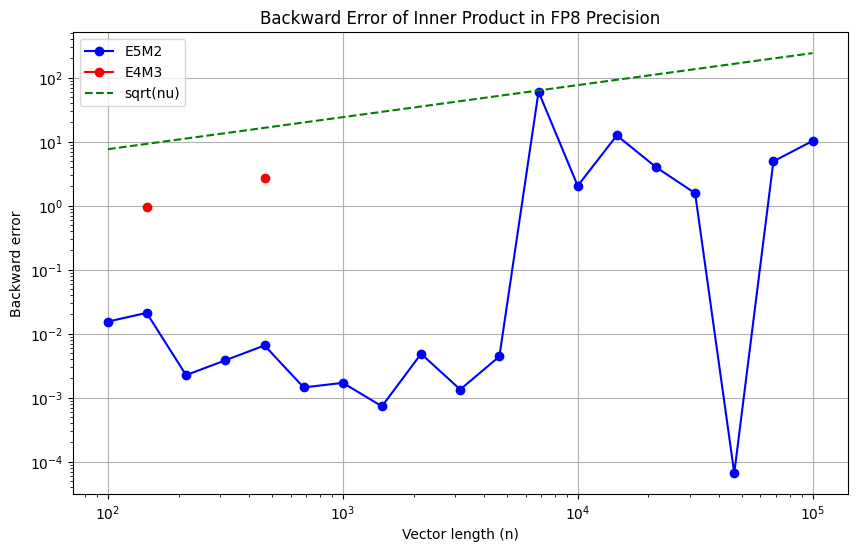

E5M2 results:
Minimum error: 6.65e-05
Maximum error: 6.03e+01
Mean error: 5.03e+00

E4M3 results:
Minimum error: nan
Maximum error: nan
Mean error: nan


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def compute_inner_product_fp8(x, y, n_mantissa):
    x_tensor = torch.tensor(x, dtype=torch.bfloat16)
    y_tensor = torch.tensor(y, dtype=torch.bfloat16)
    
    x_fp8 = round_to_fp8_represented_as_int8(x_tensor, n_mantissa, None)
    y_fp8 = round_to_fp8_represented_as_int8(y_tensor, n_mantissa, None)
    
    x_fp8_float = undo_int8_fp8(x_fp8, n_mantissa)
    y_fp8_float = undo_int8_fp8(y_fp8, n_mantissa)
    
    return torch.dot(x_fp8_float.flatten(), y_fp8_float.flatten()).item()

def backward_error(true_result, computed_result):
    return np.abs(true_result - computed_result) / np.abs(true_result)

# Generate n values
n_values = np.logspace(2, 5, num=19, dtype=int)

# Initialize lists to store results
backward_errors_e5m2 = []
backward_errors_e4m3 = []

# Compute inner products and backward errors
for n in tqdm(n_values, desc="Computing errors"):
    # Generate x and y vectors
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    
    # Compute true result in double precision
    true_result = np.dot(x, y)
    
    # Compute result in e5m2 precision
    e5m2_result = compute_inner_product_fp8(x, y, 2)
    
    # Compute result in e4m3 precision
    e4m3_result = compute_inner_product_fp8(x, y, 3)
    
    # Compute backward errors
    error_e5m2 = backward_error(true_result, e5m2_result)
    error_e4m3 = backward_error(true_result, e4m3_result)
    
    backward_errors_e5m2.append(error_e5m2)
    backward_errors_e4m3.append(error_e4m3)

# Create the plot
plt.figure(figsize=(10, 6))
plt.loglog(n_values, backward_errors_e5m2, 'bo-', label='E5M2')
plt.loglog(n_values, backward_errors_e4m3, 'ro-', label='E4M3')

# Add sqrt(nu) line
eps = 0.0625  # e5m2 epsilon (2^-4)
sqrt_nu = np.sqrt(n_values) * eps
plt.loglog(n_values, sqrt_nu, 'g--', label='sqrt(nu)')

plt.xlabel('Vector length (n)')
plt.ylabel('Backward error')
plt.title('Backward Error of Inner Product in FP8 Precision')
plt.legend()
plt.grid(True)
plt.show()

print("E5M2 results:")
print(f"Minimum error: {min(backward_errors_e5m2):.2e}")
print(f"Maximum error: {max(backward_errors_e5m2):.2e}")
print(f"Mean error: {np.mean(backward_errors_e5m2):.2e}")

print("\nE4M3 results:")
print(f"Minimum error: {min(backward_errors_e4m3):.2e}")
print(f"Maximum error: {max(backward_errors_e4m3):.2e}")
print(f"Mean error: {np.mean(backward_errors_e4m3):.2e}")


At this point we are able to:
- Construct the full range of bfloat16, uint8
- Convert bfloat16 to bits and back
- Convert bfloat16 to sign, exponent, mantissa and back
- Test that conversion is correct except NaN values
- Truncate when bfloat16 to e5m2 with mantissa chopping
- Round up when converting from bfloat16 to e5m2

Next:
- Handle subnormal, inf, nan special cases in encode and decode 
- Round by stochastic rounding scheme